In [1]:
import numpy as np
from astropy.table import Table, join, Column
import matplotlib.pyplot as plt
from astropy import units as u

## Depletion time vs stellar surface density for EDGE.  

In [2]:
hafile = '../img_califa/edge.pipe3d.hdf5'
cofile = '../img_comom/edge.comom_smo7.hdf5'

In [3]:
cotab=Table.read(cofile, path='smo')
hatab=Table.read(hafile, path='flux_elines_sm')
sttab=Table.read(hafile, path='SSP_sm')
join2 = join(cotab,hatab)
join3 = join(join2,sttab)
print(join3.colnames)

/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


['Name', 'ix', 'iy', 'ra_off', 'dec_off', 'emom0max', 'mom0', 'emom0', 'flux_[OII]3727', 'flux_[OIII]5007', 'flux_[OIII]4959', 'flux_Hbeta', 'flux_Halpha', 'flux_[NII]6583', 'flux_[NII]6548', 'flux_[SII]6717', 'flux_[SII]6731', 'vel_[OII]3727', 'vel_[OIII]5007', 'vel_[OIII]4959', 'vel_Hbeta', 'vel_Halpha', 'vel_[NII]6583', 'vel_[NII]6548', 'vel_[SII]6717', 'vel_[SII]6731', 'disp_[OII]3727', 'disp_[OIII]5007', 'disp_[OIII]4959', 'disp_Hbeta', 'disp_Halpha', 'disp_[NII]6583', 'disp_[NII]6548', 'disp_[SII]6717', 'disp_[SII]6731', 'EW_[OII]3727', 'EW_[OIII]5007', 'EW_[OIII]4959', 'EW_Hbeta', 'EW_Halpha', 'EW_[NII]6583', 'EW_[NII]6548', 'EW_[SII]6717', 'EW_[SII]6731', 'e_flux_[OII]3727', 'e_flux_[OIII]5007', 'e_flux_[OIII]4959', 'e_flux_Hbeta', 'e_flux_Halpha', 'e_flux_[NII]6583', 'e_flux_[NII]6548', 'e_flux_[SII]6717', 'e_flux_[SII]6731', 'e_vel_[OII]3727', 'e_vel_[OIII]5007', 'e_vel_[OIII]4959', 'e_vel_Hbeta', 'e_vel_Halpha', 'e_vel_[NII]6583', 'e_vel_[NII]6548', 'e_vel_[SII]6717', 'e_vel

In [4]:
# Convert Halpha intensity to A_V-corrected SFR surface density
def sfr_ha(flux_ha, flux_hb):
    # Extinction curve from Cardelli+(1989).
    K_Ha = 2.53
    K_Hb = 3.61
    # Eq(1) from Catalan-Torrecilla+(2015). 
    A_Ha = K_Ha/(-0.4*(K_Ha-K_Hb)) * np.log10((flux_ha/flux_hb)/2.86)
    A_Ha[A_Ha < 0] = 0.
    flux_ha_cor = flux_ha * 10**(0.4*A_Ha)
    # line flux is actually flux per arcsec2
    sterad = (u.sr/u.arcsec**2).decompose()   # 206265^2
    sb_ha  = flux_ha_cor * sterad   # flux per steradian
    lsd_ha = 4*np.pi * sb_ha
    # Eq(4) from Catalan-Torrecilla+(2015).
    lumcon = 5.5e-42 * (u.solMass/u.yr) / (u.erg/u.s)
    sigsfr = (lumcon * lsd_ha).to(u.solMass/(u.pc**2*u.Gyr))
    return sigsfr

In [5]:
# Convert CO intensity to H2(+He) surface density
def msd_co(sb_co, alphaco=4.3):
    convfac = alphaco * (u.solMass/u.pc**2) / (u.K*u.km/u.s)
    sig_mol = (convfac*sb_co).to(u.solMass/u.pc**2)
    return sig_mol

In [6]:
# Convert units for stellar surface density
def stmass_pc2(stmass_as2, dist=10*u.Mpc):
    sterad = (u.sr/u.arcsec**2).decompose()   # 206265^2
    pxarea = (dist**2/sterad).to(u.pc**2)
    stmass_pc2 = 10**stmass_as2 * u.solMass / pxarea
    return stmass_pc2

In [7]:
# Operate on the detections
det = (join3['mom0']>3*join3['emom0']) & (join3['flux_Halpha']>3*join3['e_flux_Halpha'])
sig_mol = msd_co(join3['mom0'][det])
sig_sfr = sfr_ha(join3['flux_Halpha'][det],join3['flux_Hbeta'][det])
t_dep = sig_mol/sig_sfr

/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)
/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


In [8]:
# For stellar surface density we need distance
globaldir = '../dat_glob/'
califa = Table.read(globaldir+'external/edge_califa.csv', format='ascii.ecsv')
califa.add_index('Name')

stlist = []
for i in np.nonzero(det)[0]:
    stlist.append(stmass_pc2(join3['mass_ssp'][i], dist=califa.loc[
        join3['Name'][i]]['caDistMpc']*u.Mpc).value)
sig_star = np.array(stlist) * u.solMass / u.pc**2

/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/astropy/units/quantity.py:639: RuntimeWarning: invalid value encountered in greater
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


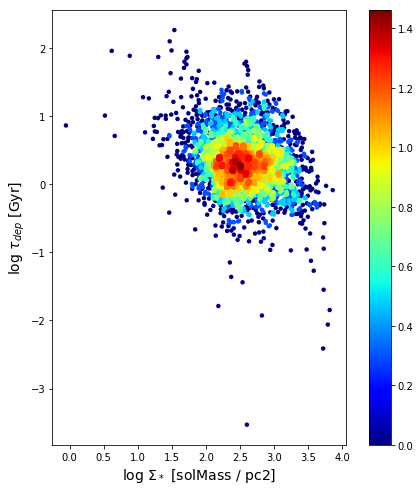

In [9]:
# Select data to plot (must be loggable)
not_nan = (~np.isnan(sig_star)) & (~np.isnan(t_dep)) & (sig_star>0) & (t_dep>0)
x = np.log10(sig_star[not_nan].value)
y = np.log10(t_dep[not_nan].value)

# Histogram the data
# https://stackoverflow.com/questions/49662964/density-scatter-plot-for-huge-dataset-in-matplotlib
bins = [100, 100]
hh, locx, locy = np.histogram2d(x, y, bins=bins)
# Get the bin value for each point
z = np.array([hh[np.argmax(a<=locx[1:]),np.argmax(b<=locy[1:])] for a,b in zip(x,y)])
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

# Make the scatter plot
fig, ax = plt.subplots(figsize=(8,8))
cm = plt.cm.get_cmap('jet')
sc = ax.scatter(x, y, c=np.log10(z), s=20, edgecolor='', cmap=cm)
plt.xlabel(r'log $\Sigma_*$ ['+str(sig_star.unit)+']',fontsize=14)
plt.ylabel(r'log $\tau_{dep}$ ['+str(t_dep.unit)+']',fontsize=14)
ax.set_aspect('equal')
plt.colorbar(sc)